In this notebook I work on the question  whether the author of a tweet (very short text) can be successfully identified.
I try to choose the best classification method its parameters set and features

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

I choose binary classification problem for the start and use Kim Kardashian and Hillary Clinton tweets

In [2]:
#data
df=pd.read_csv('C:\Kate\Python\Authorship Attribution\data\AllTweets.csv')

In [3]:
df_kk=df.loc[(df['author'] == 'KimKardashian')]
len(df_kk)

10688

In [4]:
df_hc=df.loc[(df['author'] == 'HillaryClinton')]
len(df_hc)

3356

First let's choose the same random number of tweets from both authors

In [5]:
import random
#2000 random sample rows for KK
rows = random.sample(df_kk.index, 2000)
df_kk = df_kk.ix[rows]
#2000 random sample rows for HC
rows = random.sample(df_hc.index, 2000)
df_hc = df_hc.ix[rows]
#join back together
df=df_kk.append(df_hc,ignore_index=True)
len(df)

4000

For sparsity reasons I pre-process data before analysis:
1. removing re-tweets
2. removing short messages (less then 4 words)
3. replacing @ with REF
4. replacing any url with URL
5. replacing any date with DATE
6. replacing any time with TIME
7. replace digits with NUM

In [6]:
#data pre-processing
df.drop(df[df.retweet==True].index, inplace=True)
df['num_of_words'] = df["text"].str.split().apply(len)
df.drop(df[df.num_of_words<4].index, inplace=True)
df["text"].replace(r"http\S+", "URL", regex=True,inplace=True)
df["text"].replace(r"@\S+", "REF", regex=True ,inplace=True)
df["text"].replace(r"(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})+", "DATE", regex=True,inplace=True)
df["text"].replace(r"(\d{1,2})[/:](\d{2})[/:](\d{2})?(am|pm)+", "TIME", regex=True,inplace=True)
df["text"].replace(r"(\d{1,2})[/:](\d{2})?(am|pm)+", "TIME", regex=True,inplace=True)
df["text"].replace(r"\d+", "NUM", regex=True,inplace=True)
len(df)

3817

To avoid overfitting let's hold out a part of the available data as a test set twt_test (X), author_test (Y).

In [7]:
from sklearn.cross_validation import train_test_split
twt_train, twt_test, author_train, author_test = train_test_split(df['text'], df['author'], test_size=0.4, random_state=42)

Train set length:

In [8]:
len(twt_train)

2290

Test set length:

In [9]:
len(twt_test)

1527

The place to start is to get better results from known classification method that perform well on the problem.
I test several algorithms using its default parameters as well as CountVectorizer() and TfidfTransformer() with default parameters
I also apply ten-fold cross validation on the training set to select the best method

In [10]:
ScoreSummaryByModel = list()

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
def ModelEvaluation (model,comment):
    pipeline = Pipeline([('vect', CountVectorizer())
                  , ('tfidf', TfidfTransformer())
                  , ('model', model)])
    scores = cross_val_score(pipeline, df['text'], df['author'], cv=10)	
    mean = scores.mean()	
    std = scores.std()	
    #The mean score and the 95% confidence interval of the score estimate (accuracy)
    ScoreSummaryByModel.append([comment,mean, std, "%0.3f (+/- %0.3f)" % (mean, std * 2)])
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [12]:
from sklearn.naive_bayes import MultinomialNB
ModelEvaluation (MultinomialNB(),'Naive Bayes classifier')

Accuracy: 0.934 (+/- 0.023)


Naive Bayes classifier results are not very impressive. It's just a baseline

In [13]:
from sklearn.naive_bayes import BernoulliNB
ModelEvaluation (BernoulliNB(binarize=0.0),'Bernoulli Naive Bayes')

Accuracy: 0.944 (+/- 0.024)


Bernoulli Naive Bayes reasults looks better

In [14]:
from sklearn.svm import LinearSVC
ModelEvaluation (LinearSVC(),'LinearSVC')

Accuracy: 0.943 (+/- 0.013)


LinearSVC looks Ok Maybe parameters tuning of the method improve the results

In [15]:
from sklearn.svm import SVC
ModelEvaluation (SVC(),'SVC, default rbf kernel')

Accuracy: 0.515 (+/- 0.001)


Ups :( Default rbf kernel definetly does not work

In [16]:
ModelEvaluation (SVC(kernel='linear'),'SVC, linear kernel')

Accuracy: 0.943 (+/- 0.014)


Well, SVC with linear kernel should be not worse then LinearSVC

In [17]:
from sklearn.linear_model import SGDClassifier
ModelEvaluation (SGDClassifier(),'SGD')

Accuracy: 0.942 (+/- 0.018)


Linear classifiers (SVM, logistic regression, a.o.) with SGD training should also be good for the problem. Let's try to optimize its parameters

Here is the summary. Bernoulli Naive Bayes with default parameters returned teh best accuracy

In [18]:
df_ScoreSummaryByModel=DataFrame(ScoreSummaryByModel,columns=['Method','Mean','Std','Accuracy'])
df_ScoreSummaryByModel.sort_values(['Mean'],ascending=False,inplace=True)
df_ScoreSummaryByModel

,Method,Mean,Std,Accuracy
1,Bernoulli Naive Bayes,0.943685,0.011849,0.944 (+/- 0.024)
4,"SVC, linear kernel",0.942895,0.006942,0.943 (+/- 0.014)
2,LinearSVC,0.942894,0.006748,0.943 (+/- 0.013)
5,SGD,0.942370,0.009249,0.942 (+/- 0.018)
0,Naive Bayes classifier,0.933994,0.011551,0.934 (+/- 0.023)
3,"SVC, default rbf kernel",0.515064,0.000643,0.515 (+/- 0.001)


For better features extractions let's try tokenize the text, remove stopwords (including the placeholders we added at the stage of data pre-processing) and stem the words
I will use the function in farther analysis

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """

    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    stoplist = stopwords.words('english')
    stoplist.append('twitter')
    stoplist.append('pic')
    stoplist.append('com')
    stoplist.append('net')
    stoplist.append('gov')
    stoplist.append('tv')
    stoplist.append('www')
    stoplist.append('twitter')
    stoplist.append('num')
    stoplist.append('date')
    stoplist.append('time')
    stoplist.append('url')
    stoplist.append('ref')

    text_processed = [word.lower() for word in text_processed if word.lower() not in stoplist]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    

    return text_processed

I use the grid search approach for parameter tuning. It will methodically build and evaluate a model for each combination of 
algorithm parameters and feature sets.

In [20]:
ScoreSummaryByModelParams = list()

In [21]:
from sklearn.grid_search import GridSearchCV
def ModelParamsEvaluation (vectorizer,model,params,comment):
    pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('clf', model),
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, verbose=1)
    grid_search.fit(df['text'], df['author'])
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        ScoreSummaryByModelParams.append([comment,grid_search.best_score_,"\t%s: %r" % (param_name, best_parameters[param_name])])

In [22]:
p = {'vect__analyzer':('char', 'char_wb'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((2, 2), (3, 3)), 
    'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
ModelParamsEvaluation(CountVectorizer(),BernoulliNB(),p,'Bernoulli Naive Bayes')

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   56.5s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.0min finished


Best score: 0.965
Best parameters set:
	clf__alpha: 0.001
	vect__analyzer: 'char_wb'
	vect__max_df: 0.5
	vect__ngram_range: (3, 3)


It makes sense. 3 chars is almost a word (in actual use, the average is 4.79 letters per word, and 80% are between 2 and 7 letters long according to http://norvig.com/mayzner.html). Other classification methods tests provided the same result - using 3 chars is the best approach. I do not include the results for other methods in the notebook. I tested them on my local computer. Interesting, the score is higher then for word analyzer.

In [23]:
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)), 
    'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
ModelParamsEvaluation(CountVectorizer(analyzer='word'),BernoulliNB(),p,'Bernoulli Naive Bayes, analyzer=word')

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   18.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.2min


Best score: 0.949
Best parameters set:
	clf__alpha: 0.1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.4min finished


I, actually, expected better results for longer ngrams. Maybe becasue tweets are short messages, unigrams make more sense. Other classification methods tests provided the same result - using unigrams is the best approach. I do not include the results for other methods in the notebook. I tested them on my local computer

In [24]:
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)), 
    'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
ModelParamsEvaluation(CountVectorizer(analyzer='word',tokenizer=text_process),BernoulliNB(),p,'Bernoulli Naive Bayes, analyzer=word, tokenizer=text_process')

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  6.4min finished


Best score: 0.944
Best parameters set:
	clf__alpha: 0.1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


Not a big difference if I use tokenizer. The result even slightly worse. Other classification methods tests provided the same result. I do not include the results for other methods in the notebook. I tested them on my local computer

Now let's try the combination of all vectors with discovered parameters. FeatureUnion concatenates results of multiple transformer objects.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 1),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector)])
p = {'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
ModelParamsEvaluation(vectorizer,BernoulliNB(),p,'Bernoulli Naive Bayes, vectorizer')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.8s finished


Best score: 0.966
Best parameters set:
	clf__alpha: 0.0001


The result is becomes better on the combination.
Let's try to add tokenized vector

In [26]:
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
text_vector = CountVectorizer(analyzer='word',tokenizer=text_process,ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector),("text", text_vector)])
p = {'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
ModelParamsEvaluation(vectorizer,BernoulliNB(),p,'Bernoulli Naive Bayes, vectorizer+text_vector')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   45.8s finished


Best score: 0.967
Best parameters set:
	clf__alpha: 0.001


The result improves a little bit.

In [27]:
#LinearSVC
p = {'vect__analyzer':('char', 'char_wb'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((2, 2), (3, 3)),
    'clf__C': (1,0.1,0.01,0.001,0.0001)
    }
ModelParamsEvaluation(CountVectorizer(),LinearSVC(),p,'LinearSVC')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   50.4s finished


Best score: 0.969
Best parameters set:
	clf__C: 1
	vect__analyzer: 'char'
	vect__max_df: 0.75
	vect__ngram_range: (3, 3)


In [28]:
#LinearSVC
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)),
    'clf__C': (1,0.1,0.01,0.001,0.0001)
    }
ModelParamsEvaluation(CountVectorizer(analyzer='word'),LinearSVC(),p,'LinearSVC analyzer=word')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   18.5s


Best score: 0.937
Best parameters set:
	clf__C: 1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min finished


In [29]:
#LinearSVC
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector)])
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation(vectorizer,LinearSVC(),p,'LinearSVC vectorizer')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   13.4s finished


Best score: 0.961
Best parameters set:
	clf__C: 1


In [30]:
#LinearSVC
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
text_vector = CountVectorizer(analyzer='word',tokenizer=text_process,ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector),("text", text_vector)])
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation(vectorizer,LinearSVC(),p,'LinearSVC vectorizer+text_vector')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   36.1s finished


Best score: 0.960
Best parameters set:
	clf__C: 1


In [31]:
#SVC, linear kernel
p = {'vect__analyzer':('char', 'char_wb'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((2, 2), (3, 3)),
     'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation (CountVectorizer(),SVC(kernel='linear'),p,'SVC, linear kernel, char')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 17.7min finished


Best score: 0.968
Best parameters set:
	clf__C: 1
	vect__analyzer: 'char'
	vect__max_df: 0.5
	vect__ngram_range: (3, 3)


In [32]:
#SVC, linear kernel
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)),
    'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation (CountVectorizer(analyzer='word'),SVC(kernel='linear'),p,'SVC, linear kernel, analyzer=word')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  5.5min finished


Best score: 0.938
Best parameters set:
	clf__C: 1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [33]:
#SVC, linear kernel
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)),
     'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation (CountVectorizer(analyzer='word',tokenizer=text_process),SVC(kernel='linear'),p,'SVC, linear kernel, analyzer=word, tokenizer=text_process')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.4min finished


Best score: 0.929
Best parameters set:
	clf__C: 1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [34]:
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector)])
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation(vectorizer,SVC(kernel='linear'),p,'SVC, linear  vectorizer')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.4min finished


Best score: 0.963
Best parameters set:
	clf__C: 1


In [35]:
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
text_vector = CountVectorizer(analyzer='word',tokenizer=text_process,ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector),("text", text_vector)])
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
ModelParamsEvaluation(vectorizer,SVC(kernel='linear'),p,'SVC, linear  vectorizer+text_vector')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.9min finished


Best score: 0.960
Best parameters set:
	clf__C: 1


In [36]:
#SGDClassifier
p = {'vect__analyzer':('char', 'char_wb'),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((2, 2), (3, 3)),
    'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
ModelParamsEvaluation (CountVectorizer(),SGDClassifier(),p,'SGD Classifier, analyzer=char')

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.9min finished


Best score: 0.968
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'elasticnet'
	vect__analyzer: 'char'
	vect__max_df: 1.0
	vect__ngram_range: (3, 3)


In [37]:
#SGDClassifier
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)),
    'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
ModelParamsEvaluation (CountVectorizer(analyzer='word'),SGDClassifier(),p,'SGD Classifier, analyzer=word')


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   20.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  3.1min


Best score: 0.935
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.7min finished


In [38]:
#SGDClassifier
p = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (3, 3), (5,5),(2,5)),
    'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
ModelParamsEvaluation (CountVectorizer(analyzer='word',tokenizer=text_process),SGDClassifier(),p,'SGD Classifier, analyzer=word,tokenizer=text_process')


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed: 13.6min
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 16.2min finished


Best score: 0.931
Best parameters set:
	clf__alpha: 0.001
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [39]:
#SGDClassifier
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector)])
p = {'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
ModelParamsEvaluation (vectorizer,SGDClassifier(),p,'SGD Classifier, vectorizer')

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   43.5s finished


Best score: 0.966
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'l2'


In [40]:
#SGDClassifier
word_vector =  CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
text_vector = CountVectorizer(analyzer='word',tokenizer=text_process,ngram_range=(3, 3),max_df=0.75)
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector),("text", text_vector)])
p = {'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
ModelParamsEvaluation (vectorizer,SGDClassifier(),p,'SGD Classifier, vectorizer+text_vector')

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.1min finished


Best score: 0.965
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'elasticnet'


Here is the summary. And the winners are:
LinearSVC (C=1, char 3-ngrams)
SVC with linear kernel (C=1, char 3-ngams)
SGDClassifier (alpha: 0.0001, char 3-ngams)
Bernoulli Naive Bayes (alpha = 0.001 based on combination of character 3-ngrams, word unigrams and tokenized unigram)
All 4 of them returns approximately the same accuracy - 0.968

In [41]:
df_ScoreSummaryByModelParams=DataFrame(ScoreSummaryByModelParams,columns=['Method','BestScore','BestParameter'])
df_ScoreSummaryByModelParams.sort_values(['BestScore'],ascending=False,inplace=True)
df_ScoreSummaryByModelParams

,Method,BestScore,BestParameter
14,LinearSVC,0.968562,\tvect__max_df: 0.75
15,LinearSVC,0.968562,"\tvect__ngram_range: (3, 3)"
12,LinearSVC,0.968562,\tclf__C: 1
13,LinearSVC,0.968562,\tvect__analyzer: 'char'
22,"SVC, linear kernel, char",0.968300,\tvect__analyzer: 'char'
23,"SVC, linear kernel, char",0.968300,\tvect__max_df: 0.5
24,"SVC, linear kernel, char",0.968300,"\tvect__ngram_range: (3, 3)"
37,"SGD Classifier, analyzer=char",0.968300,"\tvect__ngram_range: (3, 3)"
36,"SGD Classifier, analyzer=char",0.968300,\tvect__max_df: 1.0
35,"SGD Classifier, analyzer=char",0.968300,\tvect__analyzer: 'char'


Now let's apply the discovered best approach to test data set
I use Bernoulli Naive Bayes and SGDClassifier for comparison.
Bernoulli Naive Bayes returns better accuracy on the test set: 0.971 and SGDClassifier much worse 0.653

We need score metrics and few functions now

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [44]:
def ConfusionMatrix(author_test_b,author_predictions_b):
    cm=confusion_matrix(author_test_b,author_predictions_b)
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [45]:
def PredictionEvaluation(author_test_b,author_predictions_b):
    print ('Precision: %0.3f' % (precision_score(author_test_b,author_predictions_b)))
    print ('Accuracy: %0.3f' % (accuracy_score(author_test_b,author_predictions_b)))
    print ('Recall: %0.3f' % (recall_score(author_test_b,author_predictions_b)))
    print ('F1: %0.3f' % (f1_score(author_test_b,author_predictions_b)))
    print ('Confussion matrix:')
    print (confusion_matrix(author_test_b,author_predictions_b))
    print ('ROC-AUC: %0.3f' % (roc_auc_score(author_test_b,author_predictions_b)))

Feature Vectors

In [59]:
word_vector = CountVectorizer(analyzer='word',stop_words='english',ngram_range=(1, 5),max_df=0.5)
char_vector = CountVectorizer(analyzer='char_wb',ngram_range=(3, 3),max_df=0.75)
text_vector = CountVectorizer(analyzer='word',tokenizer=text_process,ngram_range=(3, 3),max_df=0.75)
vectorizer  = FeatureUnion([("chars", char_vector),("words", word_vector),("text", text_vector)])

Bernoulli Naive Bayes pipeline

In [60]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.001)),
    ])

In [61]:
pipeline.fit(twt_train,author_train)
author_predictions = pipeline.predict(twt_test)

To evaluate the results we need to binarize labels(authors) - 'HillaryClinton' is 0 and 'KimKardashian' is 1

In [62]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
author_test_b = lb.fit_transform(author_test.values)
author_predictions_b  = lb.fit_transform(author_predictions)

In [63]:
PredictionEvaluation(author_test_b,author_predictions_b)

Precision: 0.970
Accuracy: 0.972
Recall: 0.974
F1: 0.972
Confussion matrix:
[[745  23]
 [ 20 739]]
ROC-AUC: 0.972


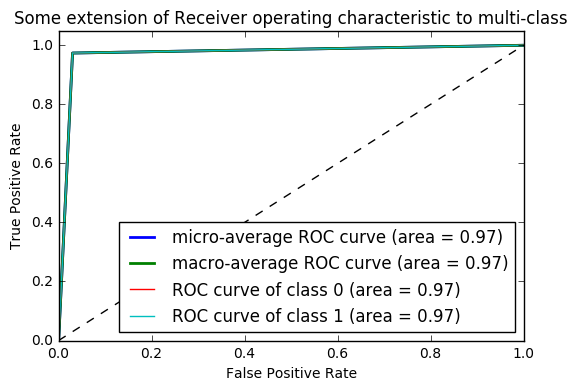

In [64]:
ROCCurves (author_test_b,author_predictions_b)

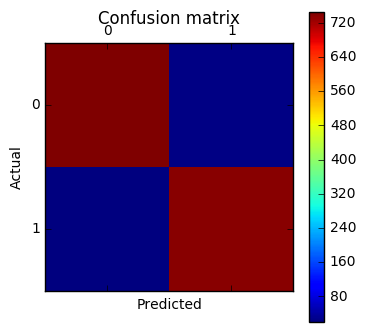

In [65]:
ConfusionMatrix(author_test,author_predictions)

SGDClassifier pipeline on the same test data with slightly higher precision but less accuracy

In [66]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='char',ngram_range=(3, 3),max_df=1)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(alpha=0.0001, penalty='elasticnet')),
    ])

In [67]:
pipeline.fit(twt_train,author_train)
author_predictions = pipeline.predict(twt_test)

In [68]:
author_test_b = lb.fit_transform(author_test.values)
author_predictions_b  = lb.fit_transform(author_predictions)

In [69]:
PredictionEvaluation(author_test_b,author_predictions_b)

Precision: 0.607
Accuracy: 0.653
Recall: 0.858
F1: 0.711
Confussion matrix:
[[346 422]
 [108 651]]
ROC-AUC: 0.654


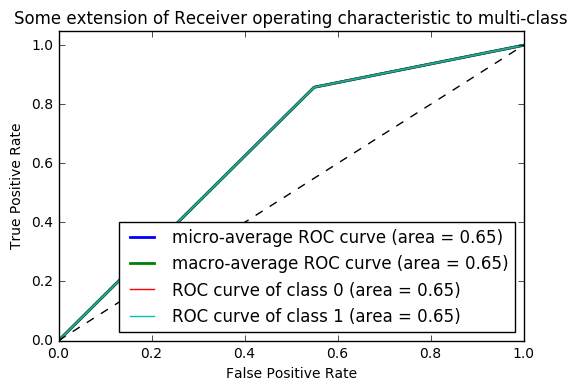

In [70]:
ROCCurves (author_test_b,author_predictions_b)

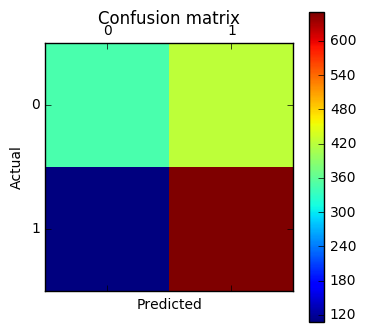

In [71]:
ConfusionMatrix(author_test_b,author_predictions_b)